# Natural Language Processing Lab
#### Sentiment Analysis, and Named Entity Recognition

In [1]:
# Import necessary libraries
#!pip install nltk
import os
import nltk
import requests
import zipfile
import tarfile
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import (
    MarianMTModel, MarianTokenizer, pipeline,
    AutoModelForSequenceClassification, AutoTokenizer
)
import spacy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from nltk.sentiment import SentimentIntensityAnalyzer
import time
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
import re
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)


# 1. Sentiment Analysis

Sentiment analysis (also called opinion mining) is a Natural Language Processing (NLP) technique used to determine the emotional tone of text. It helps in identifying whether a given text expresses a positive, negative, or neutral sentiment.

This section explores sentiment analysis using two approaches:

1. Pre-Made Tool (VADER) from NLTK – A lexicon-based approach for quick sentiment analysis.
2. Low-Level Deep Learning Model (TensorFlow/Keras) – A custom-built neural network for sentiment classification.

## Dataset Download

In [2]:
# Download IMDb dataset
def download_imdb():
    url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
    response = requests.get(url, stream=True)
    with open("aclImdb_v1.tar.gz", "wb") as f:
        f.write(response.content)
    with tarfile.open("aclImdb_v1.tar.gz", "r:gz") as tar:
        tar.extractall()
    os.remove("aclImdb_v1.tar.gz")


download_imdb()

# Load dataset


def load_imdb():
    reviews, labels = [], []
    for label in ["pos", "neg"]:
        folder = f"aclImdb/train/{label}"
        for file in os.listdir(folder)[:500]:
            with open(os.path.join(folder, file), "r", encoding="utf-8") as f:
                reviews.append(f.read())
                labels.append(1 if label == "pos" else 0)
    return reviews, labels


reviews, labels = load_imdb()

## Pre-made Tool VADER (To Be Done)

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a rule-based sentiment analysis tool available in NLTK. It uses a lexicon-based approach, assigning predefined sentiment scores to words and phrases.
The function analyze_imdb_sentiment takes in IMDb movie reviews, calculates sentiment scores using VADER, and classifies them as positive or negative.

The compound score is used to determine the final sentiment:
1. Positive (1) if the compound score is ≥ 0
2. Negative (0) otherwise

If true labels are provided, VADER’s performance is evaluated using accuracy and a classification report.


## Your Task

In this section, you will write the code that iterates over the list of reviews, obtains the sentiment scores using the VADER SentimentIntensityAnalyzer, and converts those scores to a simple binary prediction. You will then store the results in a structure that can be used for further evaluation.

Your steps should include:
1. Loop through each review in 'reviews' using a for-loop.
2. For each review, use the VADER SentimentIntensityAnalyzer to compute the sentiment scores. (Hint: You'll receive a dictionary with 'pos', 'neu', 'neg', and 'compound' scores.)
3. Convert the 'compound' score into a binary sentiment. For example:
    - If 'compound' >= 0, label it as POSITIVE.
    - Else, label it as NEGATIVE.
4. If 'true_labels' is provided, map 1 to POSITIVE and 0 to NEGATIVE.
5. Create a dictionary containing:
    {
        'review': `<the original review>`,
        'predicted_sentiment': <"POSITIVE" or "NEGATIVE" based on the prediction made>,
        'true_sentiment': <"POSITIVE" or "NEGATIVE" based on ith true_label (if it is given)>,
        'compound_score': `<the VADER compound score>`
    }
6. Append each dictionary to a 'detailed_results' list. Also maintain a 'predictions' list with 1 for POSITIVE and 0 for NEGATIVE, which will be used to evaluate accuracy and generate a classification report.

Once you have finished writing your code, confirm it runs correctly and that the output is as expected.


In [29]:
def analyze_imdb_sentiment(reviews, true_labels=None):
    """
    Analyze sentiment of IMDb reviews using NLTK's VADER sentiment analyzer.

    Args:
        reviews (list): List of IMDb review texts
        true_labels (list): Optional list of true labels for evaluation
    """
    try:
        # Download required NLTK data (only needed once)
        try:
            nltk.data.find('sentiment/vader_lexicon.zip')
        except LookupError:
            nltk.download('vader_lexicon')

        # Initialize the VADER sentiment analyzer
        sia = SentimentIntensityAnalyzer()

        # Track timing
        start_time = time.time()

        # Process reviews
        predictions = []
        detailed_results = []

        for i, review in enumerate(reviews):
            # Get sentiment scores
            scores = sia.polarity_scores(review)


            # TODO code here
            # Convert compound score to binary prediction for each review and append to predictions list (1 for positive, 0 for negative)
            compound_score = scores['compound']
            if compound_score >= 0:
              predicted_sentiment = 'POSITIVE'
              predictions.append(1)
            else:
              predicted_sentiment = 'NEGATIVE'
              predictions.append(0)

            if true_labels is not None:
              true_sentiment = 'POSITIVE' if true_labels[i] == 1 else 'NEGATIVE'
            else:
              true_sentiment = Nonet
            # Store detailed results
            detailed_results.append({
                'review' : review,
                'predicted_sentiment': predicted_sentiment,
                'true_sentiment': true_sentiment,
                'compound_score': compound_score
            })


        processing_time = time.time() - start_time

        return {
            'predictions': predictions,
            'detailed_results': detailed_results,
            'processing_time': processing_time,
            'accuracy': accuracy_score(true_labels, predictions) if true_labels else None,
            'classification_report': classification_report(true_labels, predictions) if true_labels else None
        }

    except Exception as e:
        print(f"Error during sentiment analysis: {str(e)}")
        return None

def display_results(analysis_output, num_examples=5):
    """
    Display random examples and complete results.
    """
    if not analysis_output:
        return

    results = analysis_output['detailed_results']

    # Show random examples
    print(f"\n===== {num_examples} Random Examples =====")
    random_indices = random.sample(range(len(results)), num_examples)

    for idx in random_indices:
        result = results[idx]
        preview = result['review'][:200] + '...' if len(result['review']) > 200 else result['review']
        print(f"\nReview {idx + 1}:")
        print(f"Text: {preview}")
        print(f"Predicted: {result['predicted_sentiment']}")
        print(f"Actual: {result['true_sentiment']}")
        print(f"Confidence (compound score): {result['compound_score']:.3f}")
        print("-" * 80)

    # Show complete results
    print("\n===== Complete Results =====")
    print(f"Total reviews analyzed: {len(results)}")
    print(f"Processing time: {analysis_output['processing_time']:.2f} seconds")
    print(f"Accuracy: {analysis_output['accuracy']:.4f}")
    print("\nDetailed Classification Report:")
    print(analysis_output['classification_report'])

# Run the analysis
if __name__ == "__main__":
    # Analyze the loaded IMDb dataset
    results = analyze_imdb_sentiment(reviews, labels)

    # Display random examples and complete results
    display_results(results, num_examples=5)


===== 5 Random Examples =====

Review 815:
Text: Man, I really find it hard to believe that the wonderful Alan Ball had anything to do with this mess. Having seen the first two episodes thus far, I think I can safely say this show isn't going to be ...
Predicted: NEGATIVE
Actual: NEGATIVE
Confidence (compound score): -0.851
--------------------------------------------------------------------------------

Review 778:
Text: On Broadway, A Chorus Line was pure magic. From the second the show opened with a spectacular burst of energy to the truly grand finale, a joyous curtain call of all those chorus members who we grew t...
Predicted: POSITIVE
Actual: NEGATIVE
Confidence (compound score): 0.995
--------------------------------------------------------------------------------

Review 582:
Text: You know you're in trouble when the opening narration basically tells you who survives. It all goes downhill from there. Unnecessary, "Matrix"-influenced bullet-time camera work. Pointless cuts to 

## Low Level Custom Implementation

This section explores sentiment analysis using a deep learning model built with TensorFlow and Keras. The notebook follows a structured approach to text processing and classification:

1. Data Preprocessing: Text data is tokenized and converted into padded sequences for input into the model.
2. Model Architecture: A sequential model is defined using an embedding layer, a global average pooling layer, a dense hidden layer, and a final sigmoid activation layer for binary classification.
3. Model Training: The dataset is split into training and validation sets, and the model is trained using the Adam optimizer with binary cross-entropy loss.
4. Evaluation and Prediction: The model’s performance is assessed using accuracy metrics, and sample predictions are generated to verify sentiment classification.
5. Visualization: Training history is plotted to observe accuracy and loss trends across epochs.

### Data Preprocessing (To Be Done)

Your steps should include:
1. Create a Tokenizer object with the desired vocabulary size (max_words) and set the out-of-vocabulary token (oov_token) as `<OOV>`.
2. Fit the Tokenizer on the collection of text reviews by calling 'fit_on_texts'.
3. Convert the text reviews to sequences of integers using 'texts_to_sequences'.


In [7]:
def preprocess_data(reviews, labels, max_words=10000, max_len=200):
    """
    Preprocess the text data for the model.
    """

    # TODO code here
    # Initialize and fit the tokenizer
    tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
    tokenizer.fit_on_texts(reviews)

    # Convert texts to sequences
    sequences = tokenizer.texts_to_sequences(reviews)


    # Pad sequences (that you get after converting reviews to sequences) to ensure uniform length
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

    return padded_sequences, np.array(labels), tokenizer

### Model Definition

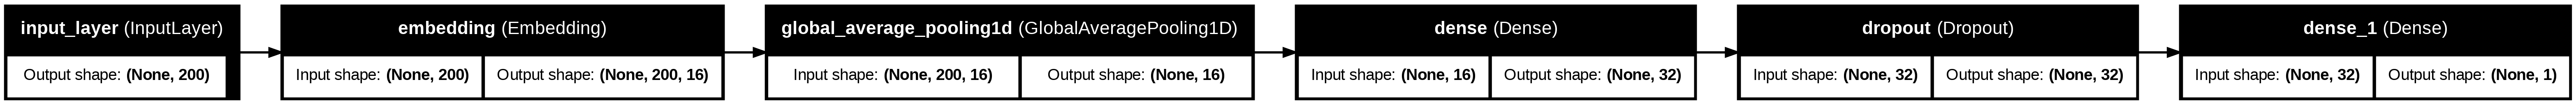

In [8]:
def create_model(vocab_size, embedding_dim=16, max_len=200):
    """
    Create a simple sequential model for sentiment analysis.
    """
    # Take a look at the figure and the model code, and try to understand it.
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_len),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

    return model

### Training the Model (To Be Done)

In this step, you'll assemble and execute the training pipeline for your sentiment analysis model.
Follow these instructions:

1. Call the `preprocess_data` function that was implemented before with your reviews and labels:
   - This should return X (padded sequences), y (labels as a NumPy array), and tokenizer.
2. Split the data into training and validation sets using `train_test_split`. Use 20% of the data for testing/validation.
3. Determine `vocab_size` by taking the minimum between `len(tokenizer.word_index) + 1` and `max_words`.
   - The `+1` accounts for indexing from 1 instead of 0 in Keras vocabulary.
4. Call the create_model function from above to build your model architecture.

In [9]:
# Train the model
def train_sentiment_model(reviews, labels, max_words=10000, max_len=200, embedding_dim=16, epochs=10):
    """
    Train the sentiment analysis model.
    """
    # TODO code here
    # Preprocess data
    X, y, tokenizer = preprocess_data(reviews, labels)

    # Split into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size =0.2, random_state=42)

    vocab_size = min(len(tokenizer.word_index) + 1, max_words)

    # Create the model
    model = create_model(vocab_size, embedding_dim, max_len)

    # Train model (Change the variable names here according to what you used above)
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        validation_data=(X_val, y_val),
        batch_size=32,
        verbose=1
    )

    return model, tokenizer, history

print("Training model...")
model, tokenizer, history = train_sentiment_model(reviews, labels, epochs=25)

Training model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.4945 - loss: 0.6931 - val_accuracy: 0.4800 - val_loss: 0.6922
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5052 - loss: 0.6920 - val_accuracy: 0.6000 - val_loss: 0.6908
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6003 - loss: 0.6902 - val_accuracy: 0.5100 - val_loss: 0.6891
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6259 - loss: 0.6869 - val_accuracy: 0.6150 - val_loss: 0.6862
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7013 - loss: 0.6795 - val_accuracy: 0.7350 - val_loss: 0.6807
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7979 - loss: 0.6682 - val_accuracy: 0.6700 - val_loss: 0.6687
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7842 - loss: 0.6474 - val_accuracy: 0.7100 - val_loss: 0.6493
Epoch 8/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8393 - loss: 0.6070 - val_accuracy: 0.7700 - val_loss

### Evaluation and Prediction

In [10]:
def evaluate_model(model, tokenizer, reviews, labels, max_len=200):
    """
    Evaluate the model and show some predictions.
    """
    # Preprocess test data
    sequences = tokenizer.texts_to_sequences(reviews)
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

    # Get predictions
    predictions = model.predict(padded_sequences)

    # Print some random examples
    indices = np.random.randint(0, len(reviews), 5)
    print("\n===== Example Predictions =====")
    for idx in indices:
        pred_sentiment = "Positive" if predictions[idx] >= 0.5 else "Negative"
        true_sentiment = "Positive" if labels[idx] == 1 else "Negative"
        print(f"\nReview preview: {reviews[idx][:200]}...")
        print(f"Predicted sentiment: {pred_sentiment} (confidence: {predictions[idx][0]:.3f})")
        print(f"Actual sentiment: {true_sentiment}")

    # Calculate overall accuracy
    pred_labels = (predictions >= 0.5).astype(int)
    accuracy = np.mean(pred_labels.flatten() == labels)
    print(f"\nOverall accuracy: {accuracy:.4f}")
print("\nEvaluating model...")

evaluate_model(model, tokenizer, reviews, labels)


Evaluating model...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

===== Example Predictions =====

Review preview: I have to vote this 10 out of 10 in the rare chance that she happens to see this review, takes pity on me, whisks me to Hollywood and involves me in her freaky/funny world. But in all seriousness, it ...
Predicted sentiment: Positive (confidence: 0.980)
Actual sentiment: Positive

Review preview: Maybe I'm a sap but this is the sweetest movies ever! I saw it for the first time when I was around 4 or 5, and I cried my eyes out. Between then and now (embarrassed at age 15) I have seen it over 25...
Predicted sentiment: Positive (confidence: 0.786)
Actual sentiment: Positive

Review preview: This review may contain some SPOILERS.<br /><br />Just when you thought they didn't make them so extremely bad anymore, along comes Rae Dawn Chong as a space vixen and Willie Nelson as a Native Americ...
Predicted sentiment: Negative (confidence: 0.008)
Actual sentiment: Negative

Review previ

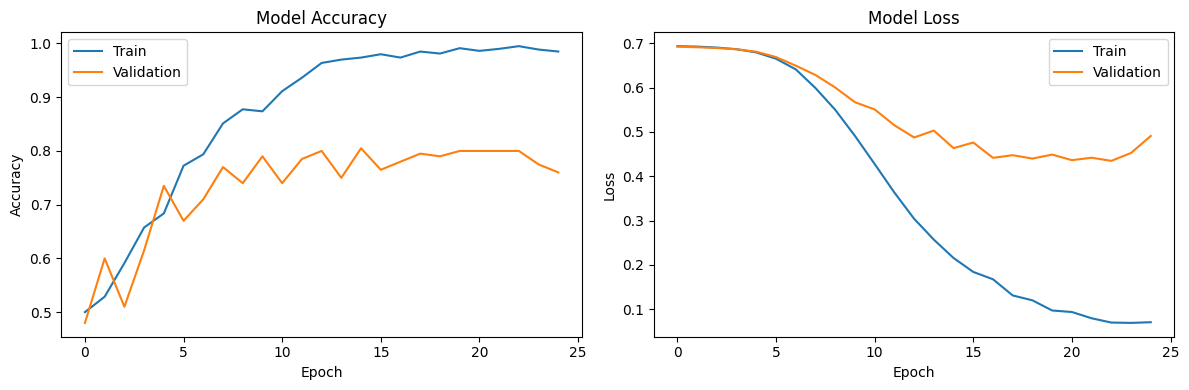

In [11]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()

## Analysis
1. Compare the Accuracies of the custom implementation and the pre-made tool. Which one performed better?
2. The code below uses a pre-trained BERT-based sentiment analysis model. Enter some of the inputs from above which were not correctly classified by the above implementations and comment on the results (if the outputs were accurate or not).

In [13]:
from transformers import pipeline
sentiment_pipeline=pipeline("sentiment-analysis")
result=sentiment_pipeline("") #enter the review here
print(result)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda:0


In [28]:
result=sentiment_pipeline("Should have been titled 'Balderdash!' Little in the film is true except the name of the island and the fact submarines were involved. Little more than training film quality with poor camera work, mudd") #enter the review here
print(result)

[{'label': 'NEGATIVE', 'score': 0.9997912049293518}]


In [31]:
result=sentiment_pipeline("On Broadway, A Chorus Line was pure magic. From the second the show opened with a spectacular burst of energy to the truly grand finale, a joyous curtain call of all those chorus members who we grew") #enter the review here
print(result) #wrongy predicted

[{'label': 'POSITIVE', 'score': 0.9998577833175659}]


In [26]:
result=sentiment_pipeline("Its about time that Gunga Din is released on DVD. I cannot accurately say how many times I have watched this fine film but, I never tire of it. The lead actors worked so well together. Victor Mclaglen") #enter the review here
print(result)

[{'label': 'POSITIVE', 'score': 0.9994908571243286}]


In [14]:
result=sentiment_pipeline("First of all, I have to say I have worked for blockbuster and have seen quite a few movies to the point its tough for me to find something I haven't seen. Taking this into account, I want everyone to") #enter the review here
print(result)

[{'label': 'POSITIVE', 'score': 0.9911991953849792}]


In [15]:
result=sentiment_pipeline("shut it off. The prologue with Fu Manchu's birthday, and the opening credits of the assassins training, is amusing. Then it drops off faster than hair sprayed with Neat. Look for a cameo by Cato i") #enter the review here
print(result)

[{'label': 'NEGATIVE', 'score': 0.9057133197784424}]


In [16]:
result=sentiment_pipeline("Hey if you have a little over an hour to kill and find paint to be too exciting I'd suggest it. If thou you happen to like cheap b-movies like me it's good for a giggle! Other than that I wouldn't sug") #enter the review here
print(result)

[{'label': 'NEGATIVE', 'score': 0.8806878328323364}]


In [17]:
result=sentiment_pipeline("TeA Turkish Bath sequence in a film noir located in New York in the 50's, that must be a hint at something ! Something that curiously, in all the previous comments, no one has pointed out , but seem") #enter the review here
print(result)

[{'label': 'POSITIVE', 'score': 0.9801269769668579}]


In [22]:
result=sentiment_pipeline("Don't get me wrong, this is a terrible, clichéd film, but it is a delight for fans of Olivia Hussey - quite possibly the most intoxicating beauty ever to grace the silver screen. One poster stated tha") #enter the review here
print(result) #wrongly predicted

[{'label': 'POSITIVE', 'score': 0.9997648596763611}]


In [23]:
result=sentiment_pipeline("I'll make this short and sweet....this movie sucked!!!!!!<br /><br />I watched part 1 earlier today and thought it was one of the greatest films ever, gave it 9 out of 10 stars. So I thought perhaps") #enter the review here
print(result)

[{'label': 'NEGATIVE', 'score': 0.9872410297393799}]


In [24]:
result=sentiment_pipeline("What do you expect when there is no script to begin with, and therefore nothing that the director can work with. Hayek and Farrell, and Donaldson and Kirkin are good actors, they just don't have anyth") #enter the review here
print(result)

[{'label': 'NEGATIVE', 'score': 0.9997003078460693}]


# Comments
out of ten sentiments, 2 were predicted wrong by the BERT,
over all accuracy is better for the BERT than the custom built model.
the wrongly predicted (2 out of 10) and correctly classified sentiment score is higher for the BERT model, shows the model is pretty highly confident about the classifications. some reviews wrongly predicted indicate that the model failed to understand sarcasm or naunced language like the 'Don't get me wrong, this.....' review started with negative but ended with a positive sentiment, confusing the model to predict wrong.
